# Assignment 3 
u6664231

## Question 1  Git in practice 

See commit history on public repo: https://github.com/gkb21/ASTR4004_assignment3

Also note for the first dozen or so commits I was playing around with how branching and merging worked and what I could and couldn't do so sorry for the chaos  

## Question 2 Using ADQL to Search for Bright Stars Around the Open Cluster M67

A colleague is interested in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg)
and is considering an observation proposal using the 2dF fibre positioner and HERMES
spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there
are enough bright stars in this region for observation. Your task is to assist by querying
data from Gaia DR3 and performing some basic analysis.

- #### Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)

In [1]:
from astroquery.gaia import Gaia
import pandas as pd
from astropy.table import Table # this works well for FITS data catalogues

# Define the center of Messier 67
ra_m67 = 132.825   # Right Ascension in degrees
dec_m67 = 11.8 # Declination in degrees
radius = 1.0  # Search radius in degrees
mag_limit = 14  # Magnitude limit

# Construct the query
query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN gaiaedr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiaedr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass
    ON xjoin.original_psc_source_id = tmass.designation

WHERE CONTAINS(
        POINT(gaia.ra, gaia.dec), 
        CIRCLE({ra_m67}, {dec_m67}, {radius})
    ) = 1
    AND gaia.phot_g_mean_mag < {mag_limit}
ORDER BY gaia.phot_g_mean_mag

"""

# Run the query
job = Gaia.launch_job(query)
results = job.get_results()
query_data_table = Table(results)
print(query_data_table)

693531223.py:     solution_id             DESIGNATION         ... ext_key    j_date   
                                                ...              d      
------------------- --------------------------- ... ------- ------------
1636148068921376768 Gaia DR3 608020176290124544 ...      --  2451115.016
1636148068921376768 Gaia DR3 598677041873269888 ...      -- 2450768.9557
1636148068921376768 Gaia DR3 604920240695111424 ...      -- 2450768.9551
1636148068921376768 Gaia DR3 604992258706635520 ...      -- 2450767.9772
1636148068921376768 Gaia DR3 604684326730942592 ...      -- 2451590.6908
1636148068921376768 Gaia DR3 598949304144504448 ...      -- 2451586.8422
1636148068921376768 Gaia DR3 604997202213330560 ...      -- 2450767.9966
1636148068921376768 Gaia DR3 598878424300068352 ...      -- 2450768.9362
1636148068921376768 Gaia DR3 601999250616455168 ...      -- 2451115.0061
                ...                         ... ...     ...          ...
1636148068921376768 Gaia DR3 59896411

- #### Determine how many stars are returned from the initial query.a

- #### Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.

- #### Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

- #### Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applying the cuts, determine how many stars remain.

- #### Using the remaining stars, generate a figure with two panels (1 point per panel):


(a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.


(b) A 2MASS J-Ks vs. apparent K magnitude diagram.

- #### Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch

- #### Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

## Question 3 The radial metallicity relation in simulated data 

The radial metallicity relation is a function that describes the change of metallicity -
here the gas phase metallicity $A(O) = log10(NO/NH) + 12$ - along the galactocentric
radius $R_{Gal}$.. Understanding the radial metallicity gradient in galaxies provides critical
insights into their formation and evolutionary processes, such as inside-out formation,
gas accretion, outflows, and radial migration. A lot of work has been done through
observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g.
Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand
the radial metallicity gradient!
Your colleague has just finished an exciting cosmological simulation that traces the
gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have
limited the simulation data to the positions (x, y, z) of the innermost gas particles
(RGal. < 25 kpc) and their gas phase metallicity A(O) and uploaded them as a FITS
file for you here: https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits

In [2]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Make the size and fonts larger for this presentation
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

In [3]:
import pandas as pd
from astropy.table import Table # this works well for FITS data catalogues
from astropy.io import fits # this is your more agnostic way to work for FITS images
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

#### - Download the file from the link above into **data/**. Load the file with python and then perform the following tasks to create figures that are saved in **figures/**:

In [4]:
# FITS Images
fits_file = fits.open('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits', ignore_missing_simple=True)
print(fits_file)

2843083784.py: [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x33155f2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x3319ccc50>]


In [5]:
#we can also just dump information for this fits file
print(fits_file.info())

Filename: data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   
908333465.py: None


In [6]:
#print the header for the Primary Extension
print(fits_file[0].header.items)

882215134.py: <bound method Header.items of SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    1 / Text string                                    
NAXIS1  =                  678 / Number of characters                           
VOTMETA =                    T / Table metadata in VOTable format               
EXTEND  =                    T / There are standard extensions                  
COMMENT                                                                         
COMMENT The data in this primary HDU consists of bytes which                    
COMMENT comprise a VOTABLE document.                                            
COMMENT The VOTable describes the metadata of the table contained               
COMMENT in the following BINTABLE extension.                                    
COMMENT Such a BINTABLE extension can be used on its own as a per

In [7]:
data = fits_file[1].data
data_table = Table(data)
print(data_table.colnames)

1330264487.py: ['x', 'y', 'z', 'A_O']


(a) Logarithmic density plot of RGal. vs. A(O), with a linear fit and legend.

In [8]:
# Calculate RGal from x, y, z positions
x = data_table['x']
y = data_table['y']
z = data_table['z']
A_O = data_table['A_O']  # Adjust this based on actual column name
# Calculate RGal
RGal = np.sqrt(x**2 + y**2 + z**2)

In [9]:
# Filter for RGal < 25 kpc
mask = RGal < 25
RGal_filtered = RGal
A_O_filtered = A_O

In [10]:
# Prepare the linear regression model
model = LinearRegression()
model.fit(RGal_filtered.reshape(-1, 1), A_O_filtered)
# Predict metallicity for the fitted model
A_O_fit = model.predict(RGal_filtered.reshape(-1, 1))

In [11]:
# Linear fit
linear_fit = np.polyfit(RGal, A_O, 1)  # 1 for linear
m, b = linear_fit  # slope and intercept

In [12]:
import statsmodels.api as sm

# Linear model
x_with_intercept = sm.add_constant(RGal)  # Adds the intercept term
linear_model = sm.OLS(A_O, x_with_intercept).fit()

In [13]:
# Print linear model summary (with statistical info)
print(linear_model.summary())
x_smooth = np.linspace(min(RGal), max(RGal), 500)
linear_fit = linear_model.params[0] + linear_model.params[1] * x_smooth


715246859.py:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 3.513e+06
Date:                Sat, 05 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:32:08   Log-Likelihood:             5.1984e+05
No. Observations:              511520   AIC:                        -1.040e+06
Df Residuals:                  511518   BIC:                        -1.040e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1223      0.000   3.2

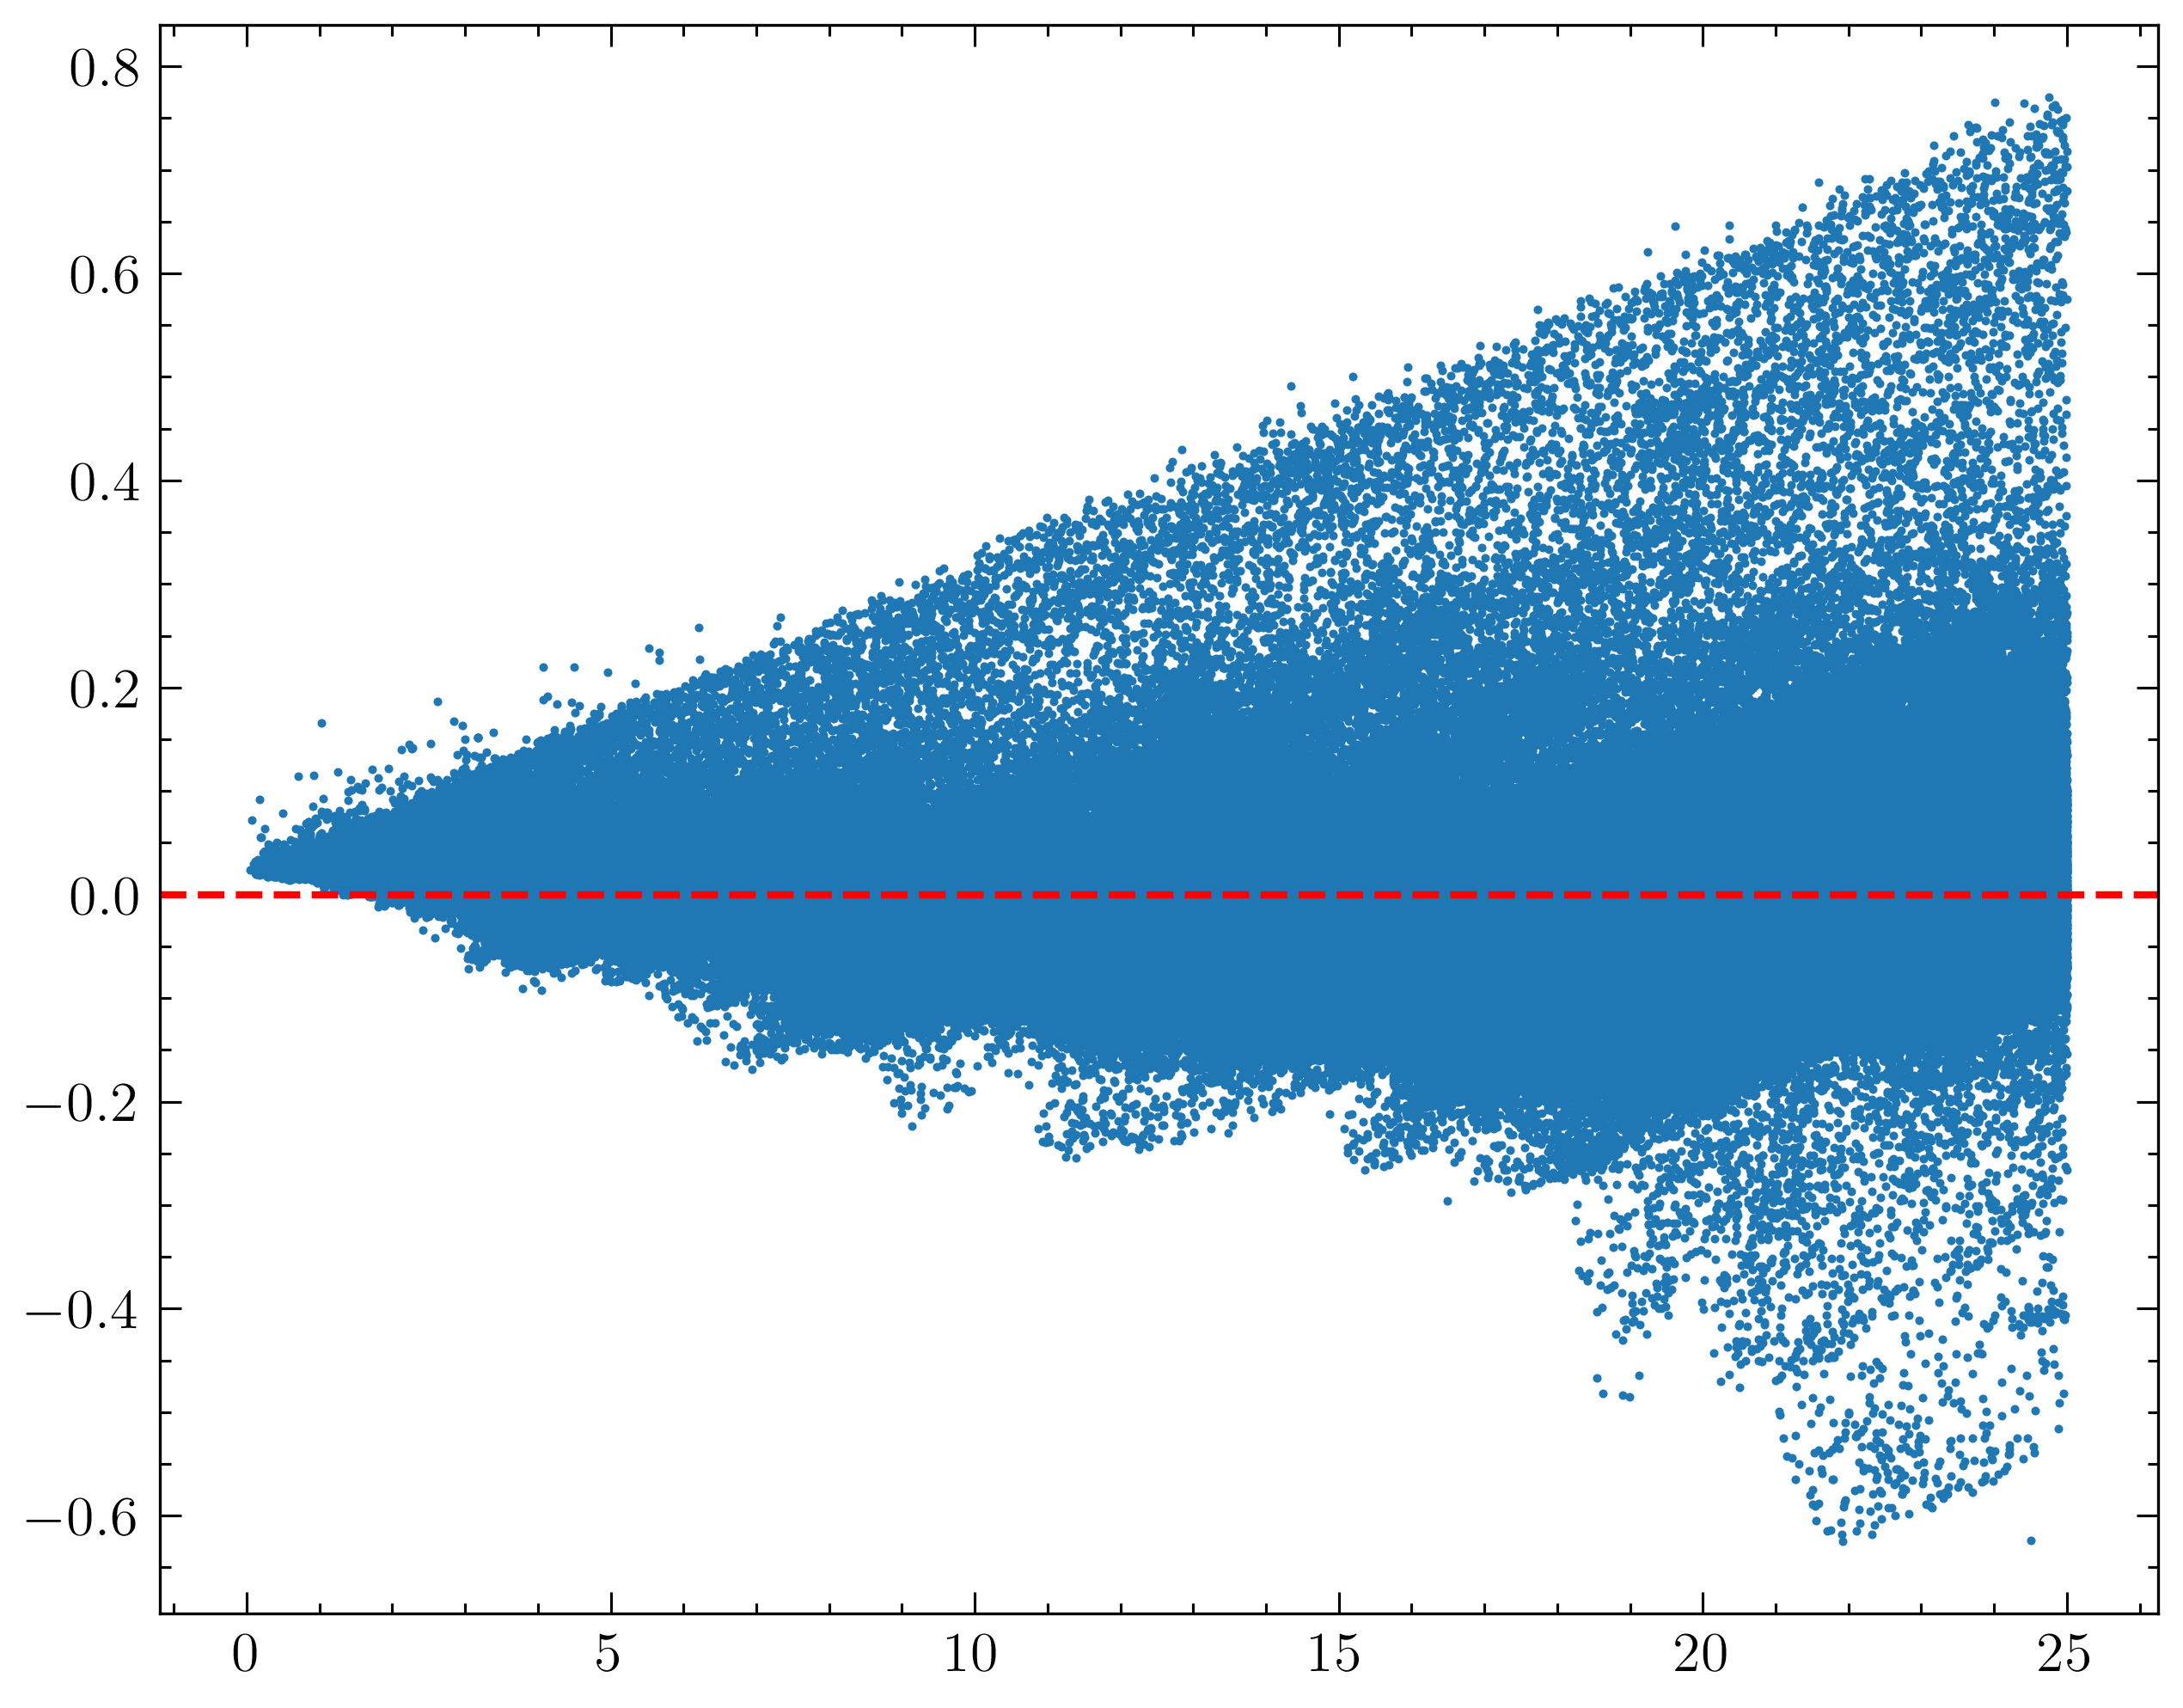

In [14]:
residuals = A_O - linear_model.predict(x_with_intercept)
plt.scatter(RGal, residuals, s=2, alpha=1)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')

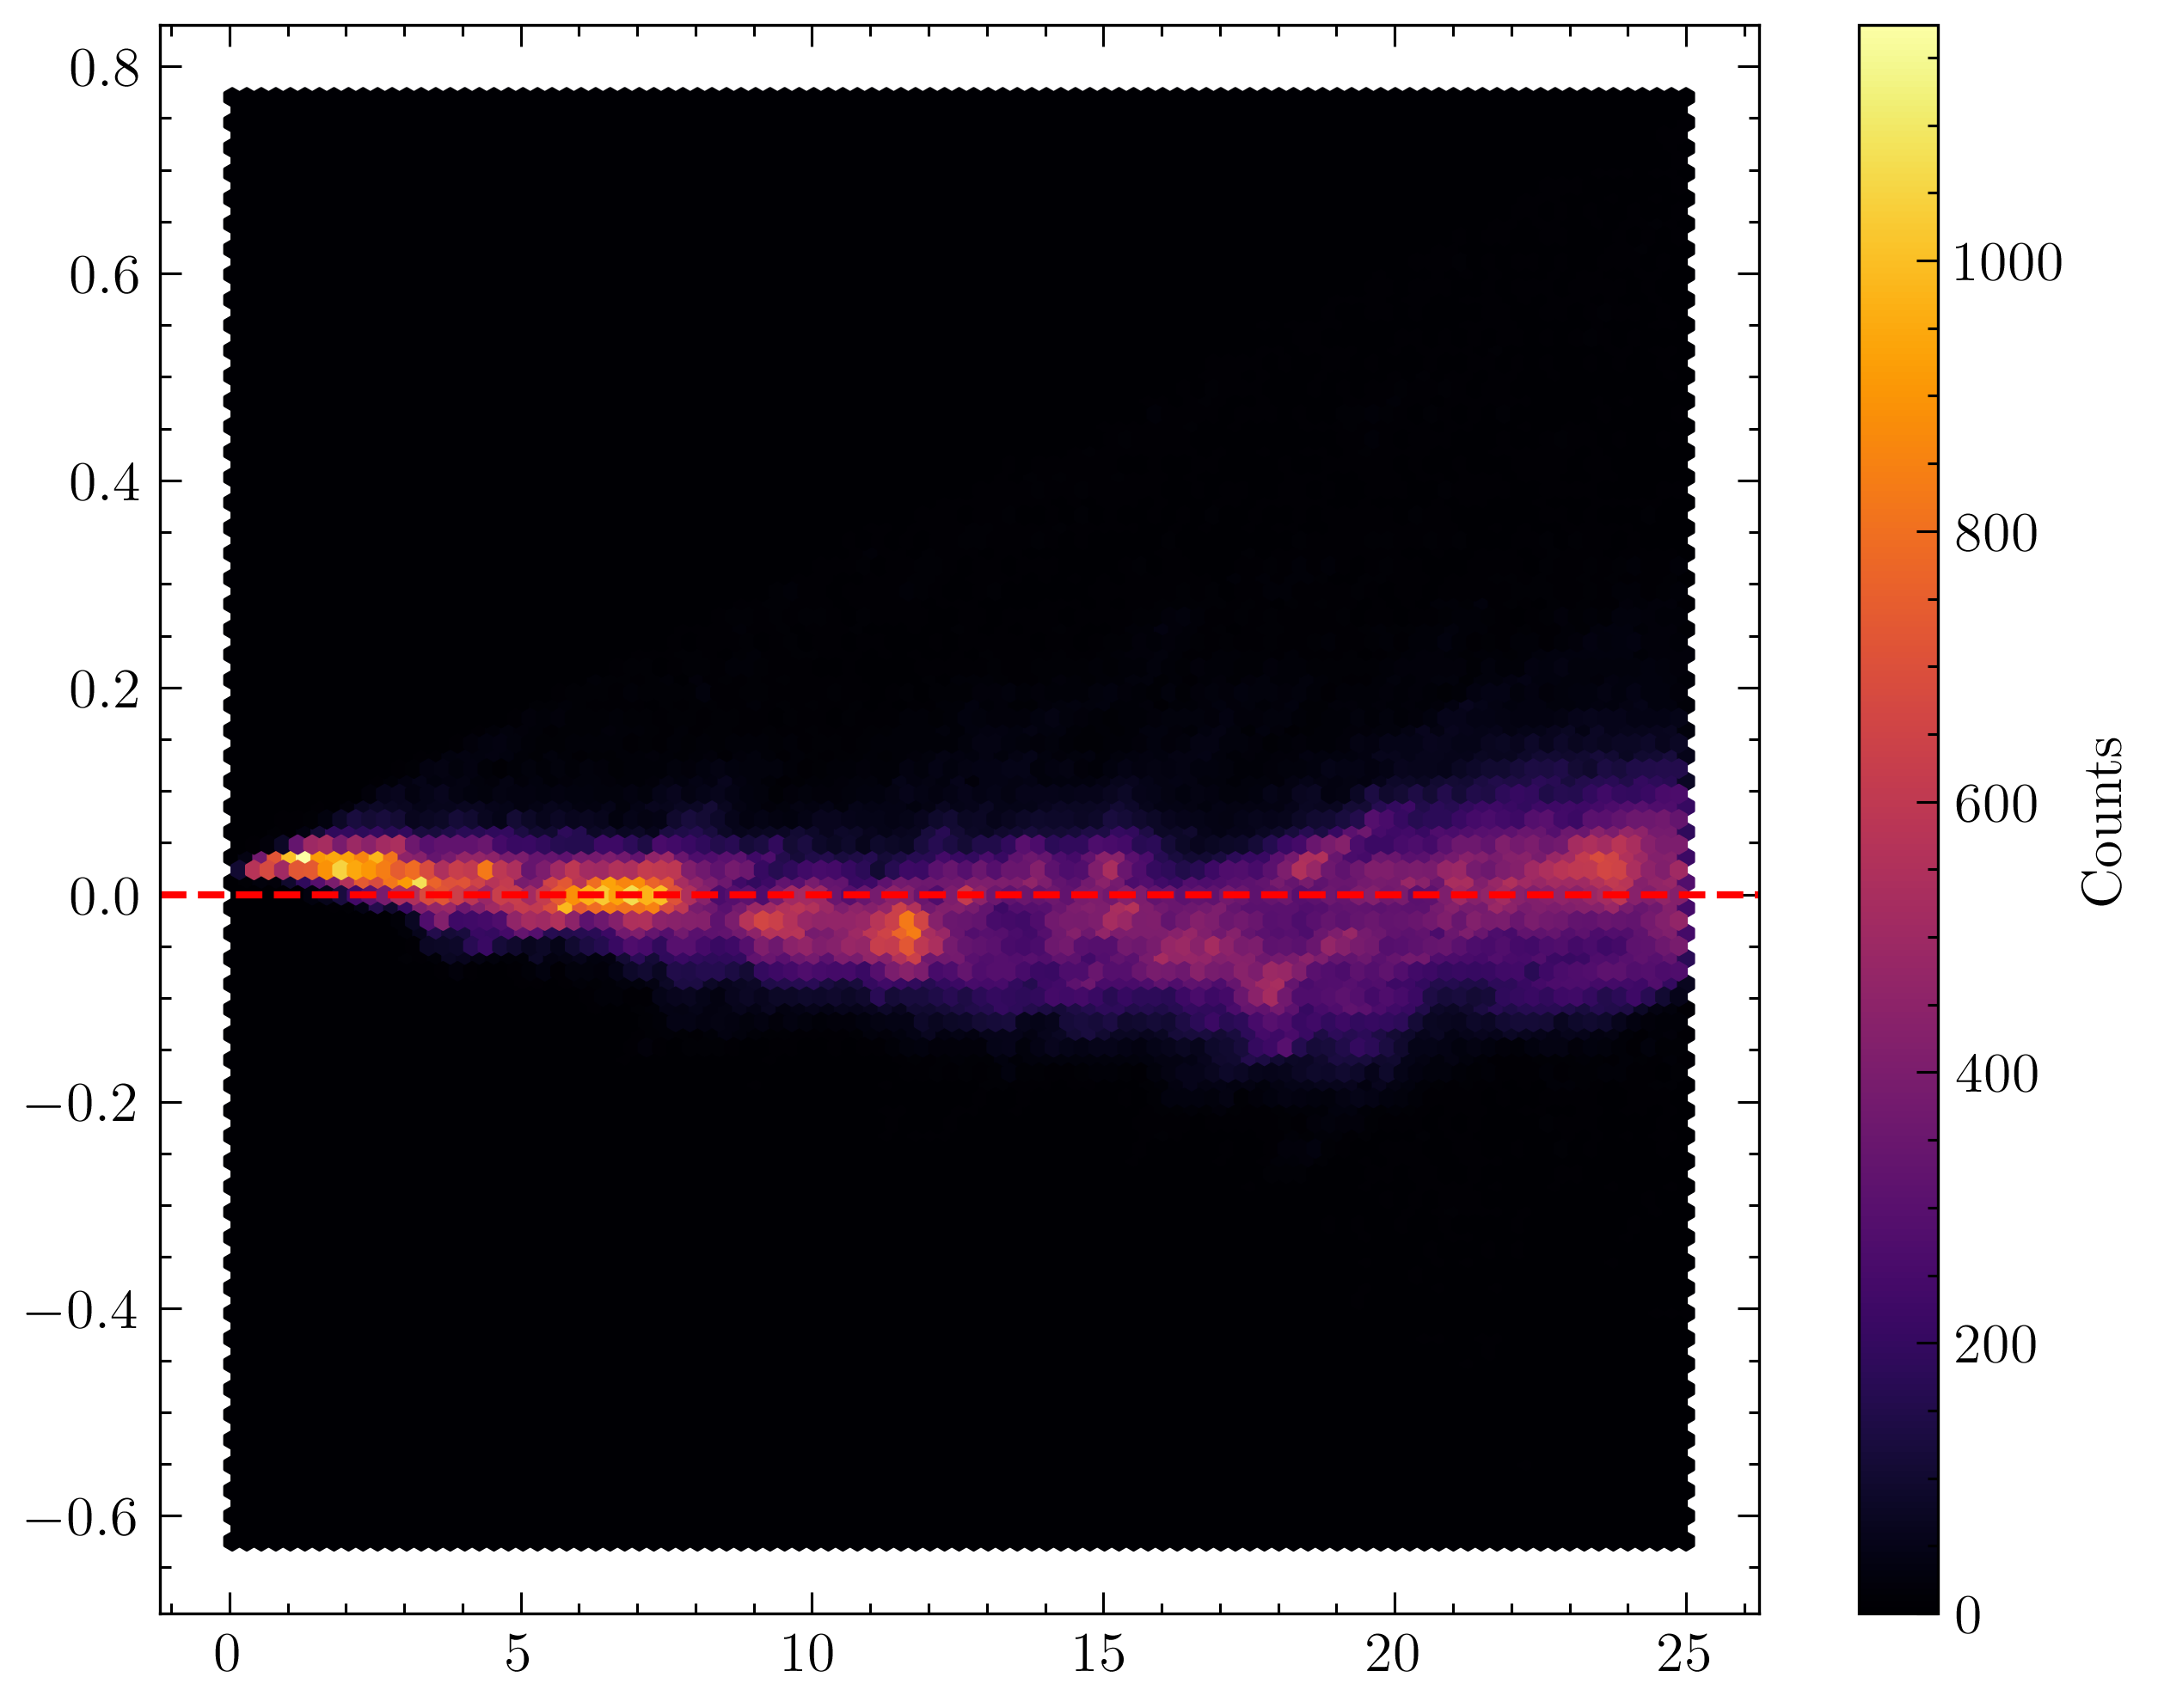

In [15]:

plt.hexbin(RGal, residuals, gridsize=100, cmap='inferno')
plt.colorbar(label='Counts')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')

In [16]:
from scipy.optimize import curve_fit

# Define linear model
def linear_model(x, m, b):
    return m * x + b

In [17]:
popt_linear, pcov_linear = curve_fit(linear_model, RGal, A_O, absolute_sigma=True)
m_linear, b_linear = popt_linear
perr_linear = np.sqrt(np.diag(pcov_linear))

In [18]:
print(f"Linear Fit: y = {m_linear:.2f}x + {b_linear:.2f}")
print(f"Linear Fit uncertainties: m = {perr_linear[0]:.2f}, b = {perr_linear[1]:.2f}")

3338144132.py: Linear Fit: y = -0.03x + 9.12
3338144132.py: Linear Fit uncertainties: m = 0.00, b = 0.00


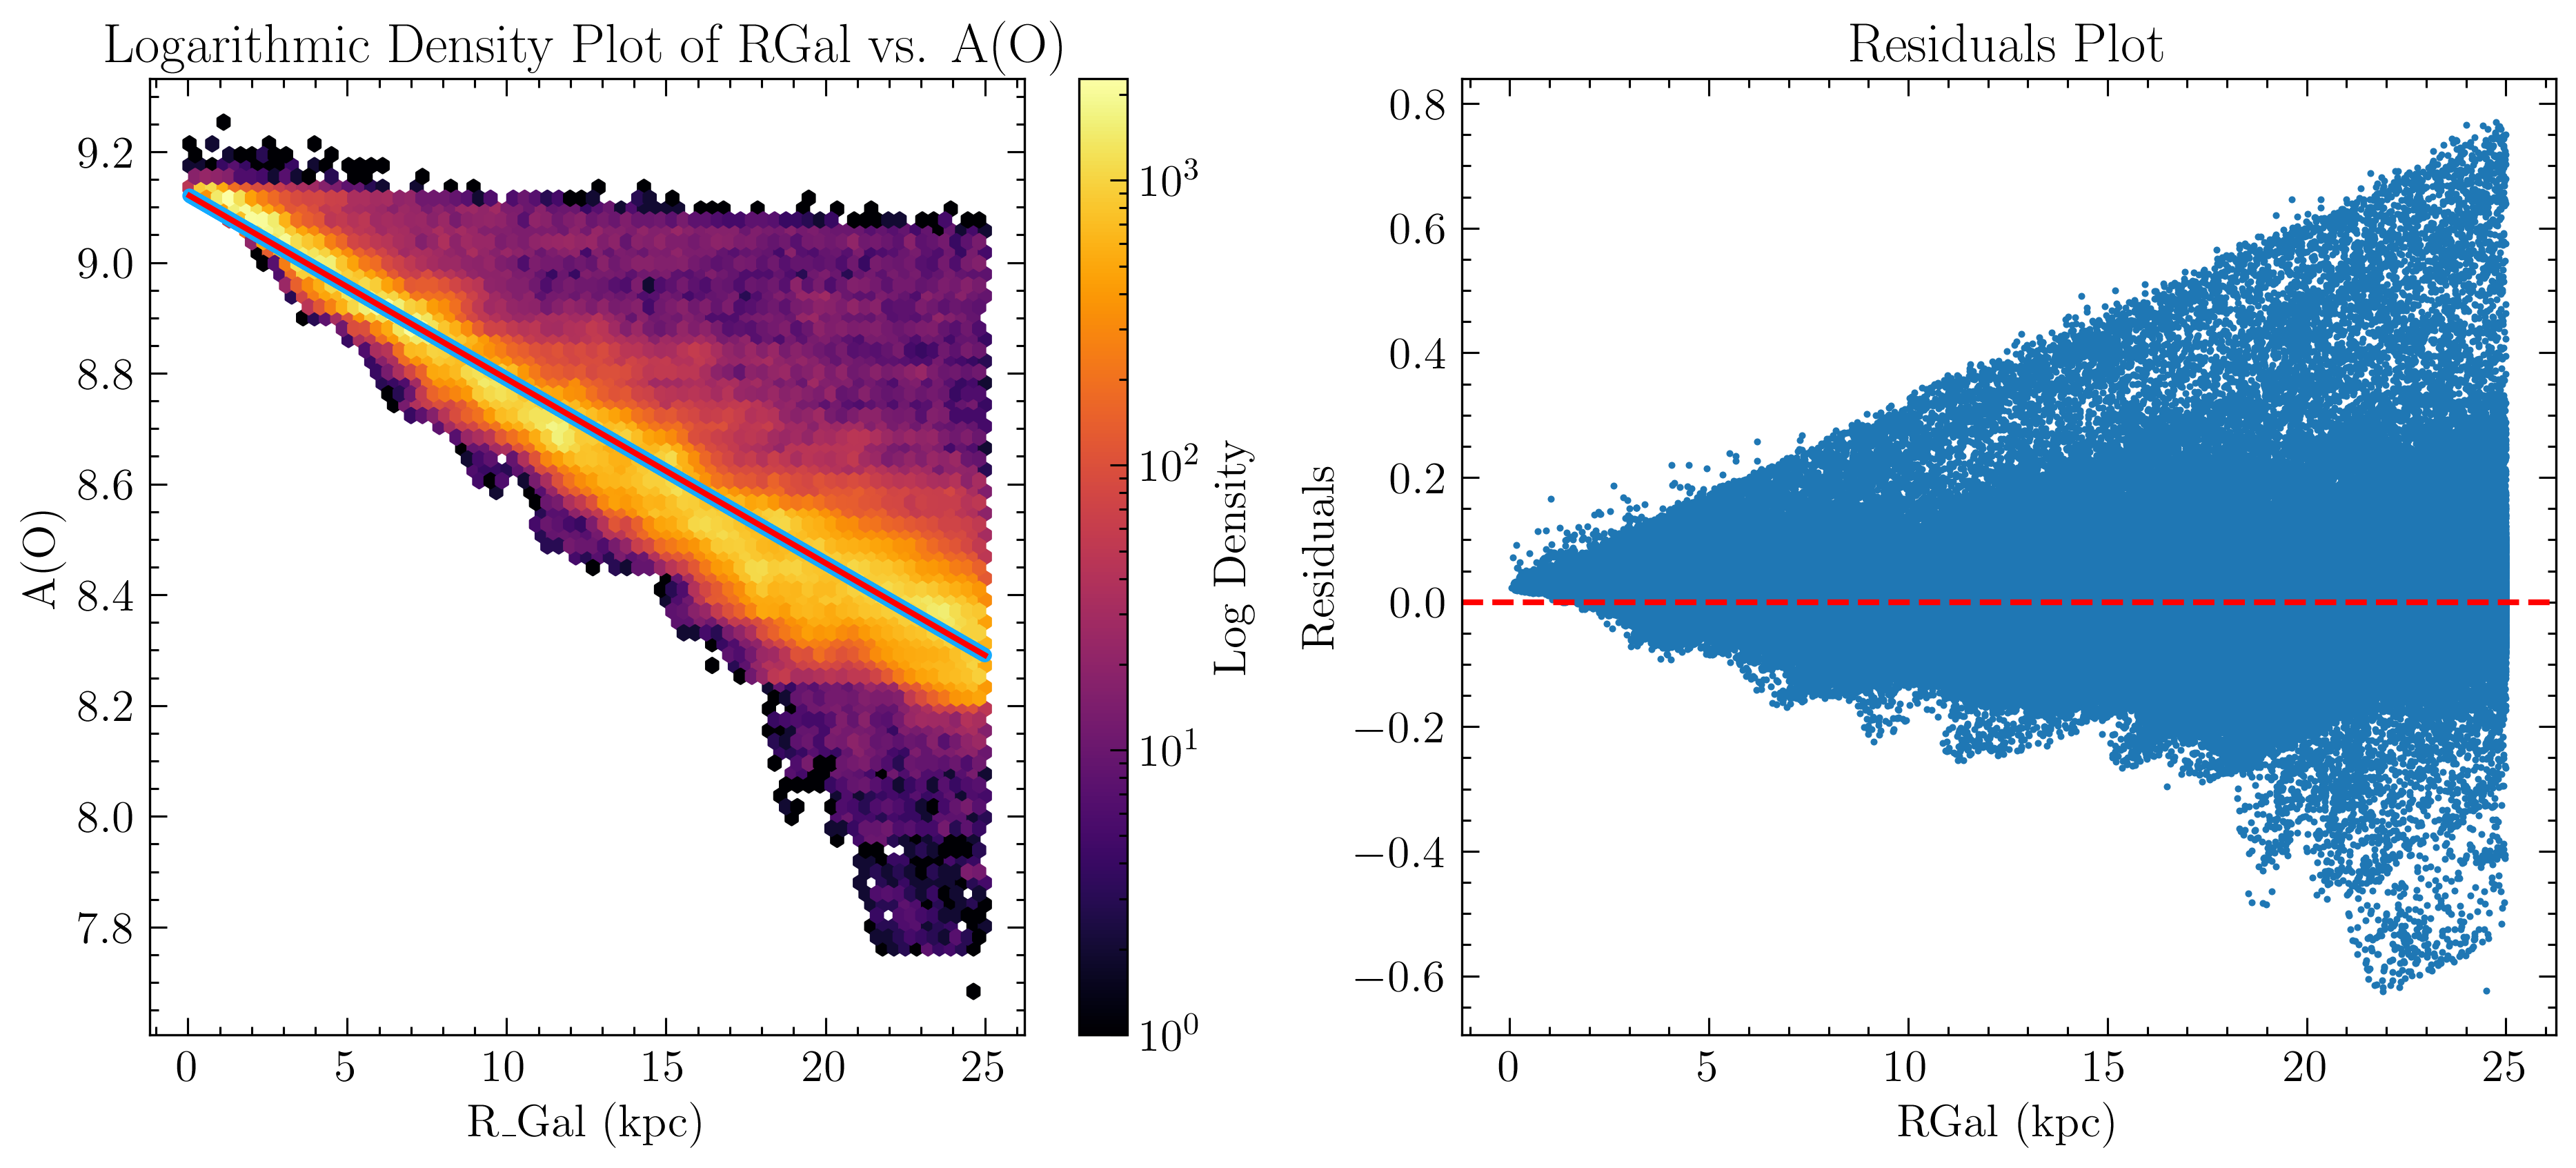

In [19]:
# Create the plot
# Create the figure
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)  # First subplot
ax2 = fig.add_subplot(122)  # Second subplot


hb = ax1.hexbin(RGal_filtered, A_O_filtered, gridsize=70, cmap='inferno', bins='log')
ax1.plot(RGal_filtered, A_O_fit, color=(0.078, 0.667, 1.0), linewidth=5,label='Linear Fit')
ax1.plot(x_smooth, linear_fit, label='Linear Fit', color='red')
ax1.set_xlabel('R_Gal (kpc)')
ax1.set_ylabel('A(O)')
ax1.set_title('Logarithmic Density Plot of RGal vs. A(O)')

ax2.scatter(RGal, residuals, s=2, alpha=1)
ax2.axhline(0, color='red', linestyle='--', label='Zero Residual')
ax2.set_xlabel('RGal (kpc)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Plot')




#fit_info = f'Slope: {m:.2f}, Intercept: {b:.2f}, R²: {r_value**2:.2f}'
#ax1.legend([fitline[0]], [fit_info], loc='lower left')
plt.colorbar(hb, ax=ax1, label='Log Density')
plt.savefig('figures/RGal_vs_AO.png', bbox_inches='tight')
plt.show()
# Save the figure

plt.close()  # Close the figure to free memory

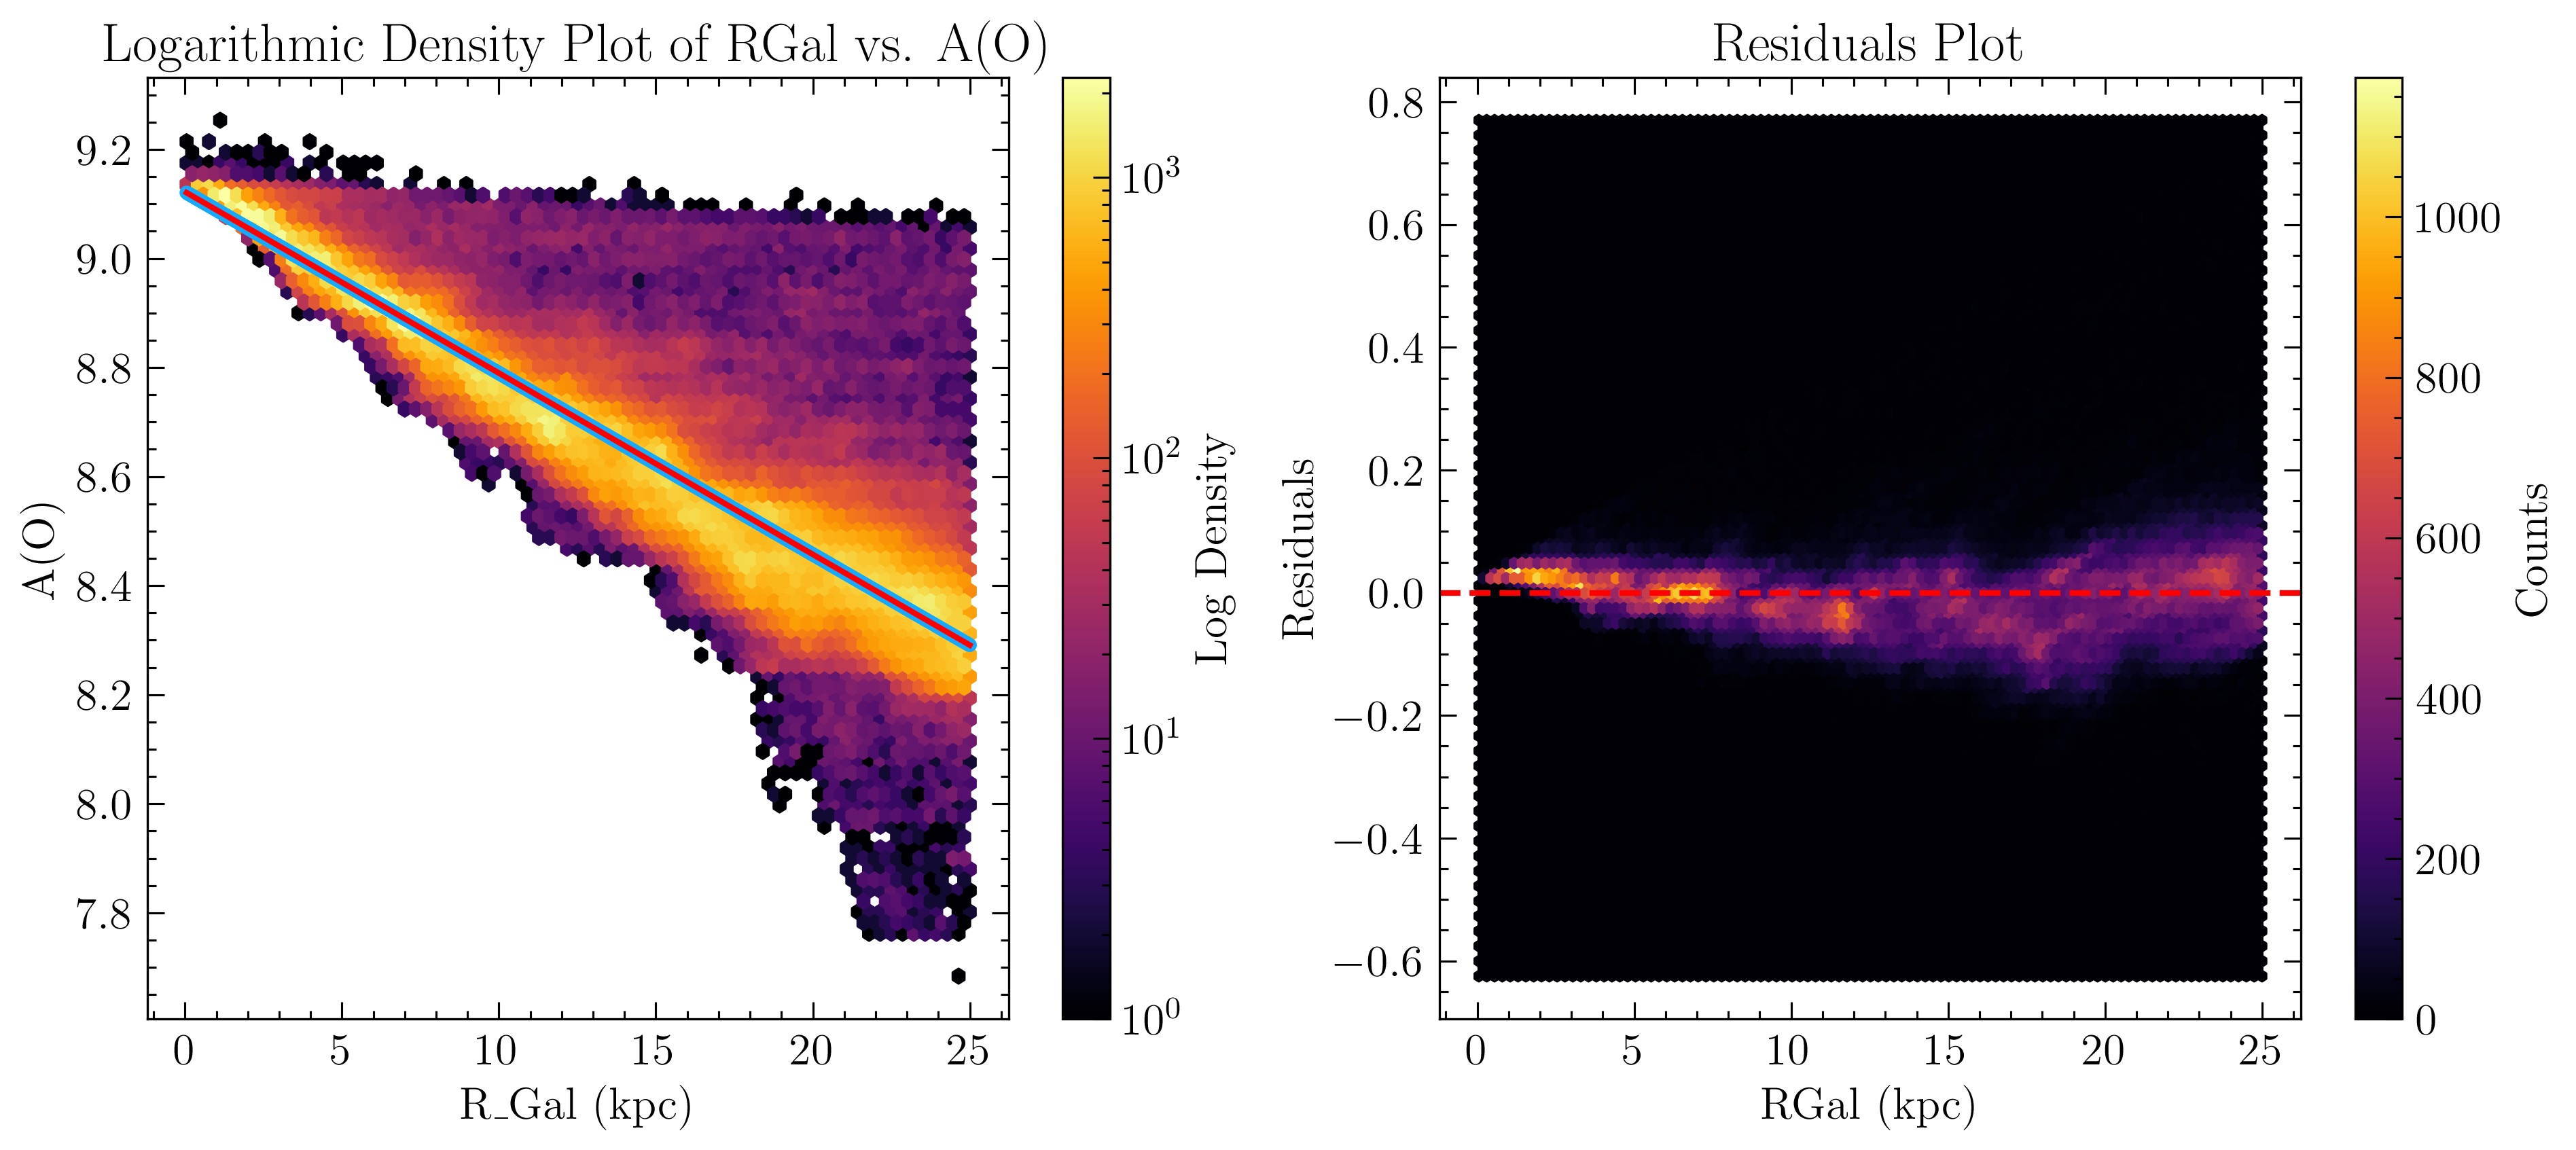

In [20]:
# Create the plot
# Create the figure
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)  # First subplot
ax2 = fig.add_subplot(122)  # Second subplot


hb = ax1.hexbin(RGal_filtered, A_O_filtered, gridsize=70, cmap='inferno', bins='log')
ax1.plot(RGal_filtered, A_O_fit, color=(0.078, 0.667, 1.0), linewidth=5,label='Linear Fit')
ax1.plot(x_smooth, linear_fit, label='Linear Fit', color='red')
ax1.set_xlabel('R_Gal (kpc)')
ax1.set_ylabel('A(O)')
ax1.set_title('Logarithmic Density Plot of RGal vs. A(O)')

hb2 = ax2.hexbin(RGal, residuals, gridsize=100, cmap='inferno')
ax2.axhline(0, color='red', linestyle='--', label='Zero Residual')
ax2.set_xlabel('RGal (kpc)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Plot')


#fit_info = f'Slope: {m:.2f}, Intercept: {b:.2f}, R²: {r_value**2:.2f}'
#ax1.legend([fitline[0]], [fit_info], loc='lower left')
plt.colorbar(hb, ax=ax1, label='Log Density')
plt.colorbar(hb2, ax=ax2, label='Counts')
plt.savefig('figures/RGal_vs_AO.png', bbox_inches='tight')
plt.show()
# Save the figure

plt.close()  # Close the figure to free memory

(b) Residuals of the fit, $R_{Gal}$. vs. $\Delta A(O)$.

#### Use a python fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include any hyperparameters used.

#### Discuss where the linear model fits well and where it does not. Use statistical metrics, such as the root mean squares or other goodness-of-fit indicators, to quantify the performance of your linear fit in general and regions with larger residuals.

#### Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:

(a) 2D-histogram of the median simulated A(O)

(b) 2D-histogram of the median fitted A(O)

(c) 2D-histogram of the median residuals ∆A(O)

#### Describe your choice of 2D bins. Discuss what details would be missed with fewer bins or problems encountered with more bins.

#### Analyze the residuals in more detail and propose an explanation for any patterns you observe.

In [21]:
fits_file.close()